# CLEWs GIS processing notebook

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Supervision:** [Abhishek Shivakumar](https://github.com/abhishek0208) & [Thomas Alfstad]() <br />
**Funding:** UN EAPD/DESA <br />

---------------------------

#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Allocating spatial index to CLEWs clusters and/or creating new clusters based on administrative level(s)
- **Part 2**: Extract GIS-based attributes to these clusters
- **Part 3**: Calculates key summary statistics for the clusters & extract them into tabular format for further use in CLEWs modelling

A slightly more detailed description of the processing bits is presented before each part below. <br />

------------

## Import necessary modules 

First things first, we need to import the necessary modules/libraries; please refer to the *clews_gis_work.yml* file for more info on the environment. You can use the yml file to directly set up the environment in conda (see [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) how). 

In [1]:
# Importing necessary python modules or libraries

# Numerical
import numpy as np
import pandas as pd
import math
from math import *

# Spatial
import geopandas as gpd
import rasterio
import rasterio.fill
from rasterstats import zonal_stats
from geojson import Feature, Point, FeatureCollection
import json
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import ogr, gdal, osr
from pyproj import CRS

#Plotting
import ipywidgets
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# System & Other
import time
import os
import datetime
start_time = time.time()

## Provide country code | type | crop name | clustering method | projection system

In [2]:
# Country name 
country_name = "lka"          # suggent using UN 3 letter ISO code

# Topological classification 
landlocked = 0                # 1 for landlocked countries (e.g. Ethiopia); 0 for coastal or island countries (e.g. Sri Lanka)

crop_name = ["mai","whe"]    # suggent using 3 letter naming convention per crop

clust_method = 1              # choose 1 for admin level 1 clustering, 2 for admin level 2 clustering and 3 for CLEWs clustering

## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32644")    # Projection system for the selected country -- see http://epsg.io/ for more info

## Provide paths and file names

For easier replication of the code you may used the following directory structure:

* **~root/country_name/input**    (a directory where your input data or files are stored)
* **~root/global_raster_input**   (a directory where your attribute raster layers are stored)

Results will be store in two automatically generated directories:
* **~root/country_name/output**   (a directory where your output data or results are stored)
* **~root/country_name/output/summary_stats**   (a directory where your tabular output data and graphs are stored)

**Note!** In case you decide to use a different structure please revise the code below.

In [3]:
# Directories
ROOT_DIR = os.path.abspath(os.curdir)
in_path = os.path.join(ROOT_DIR, country_name + "\\"+ 'input')
in_path_raster = os.path.join(ROOT_DIR, 'global_raster_input')
out_path = os.path.join(ROOT_DIR, country_name + "\\"+ 'output')
if not os.path.exists(out_path):
    try:
        os.makedirs(out_path)
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
summary_stats_path = out_path + "\\" + "summary_stats"
if not os.path.exists(summary_stats_path):
    try:
        os.makedirs(summary_stats_path)
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

# ascii file name
asci_nm = '{}_data.asc'.format(country_name)

# supporting raster name
raster_nm = "{}_data.tif".format(country_name)

# supporting vector point name
shp_nm = "{}_data.shp".format(country_name)

## Clustering method related variables
admin0_nm = '{}_adm0.gpkg'.format(country_name)             # administrative boundaries of the AoI - level0
admin1_nm = '{}_adm1.gpkg'.format(country_name)             # administrative boundaries of the AoI - level1
admin2_nm = '{}_adm2.gpkg'.format(country_name)             # administrative boundaries of the AoI - level2
clust_nm = "{}_clews_clusters.csv".format(country_name)     # CLEWs cluster name

# Name of final result file  
if clust_method == 1:
    output_nm = "{}_vector_{}_clusters".format(country_name, "admin1")
    result_nm = "{}_vector_{}_clusters_with_attributes".format(country_name, "admin1")
elif clust_method == 2:
    output_nm = "{}_vector_{}_clusters".format(country_name, "admin2")
    result_nm = "{}_vector_{}_clusters_with_attributes".format(country_name, "admin2")
else:
    output_nm = "{}_vector_{}_clusters".format(country_name, "clews")
    result_nm = "{}_vector_{}_clusters_with_attributes".format(country_name, "clews")

# Part 1 - Creating clustered polygons from ascii grid

The code in this part, creates vector polygons covering a clusterized area of interest

We focus on three types of clusters:

- Based on admin level 1
- Based on admin level 2
- Based on CLEWs clusters (read more about that [here](https://clews-gis.readthedocs.io/en/latest/))

The latter is the reason we use GAEZ ascii grid as an input; that is, to be able to provide a spatial index to the CLEWs derived clusters, which are defined based on the row, col of that grid. 

The polygons provide higher flexibility in extracting numerical and (especially) categorical raster layer stats, which might come at various spatial resolutions.  

In brief, the process has as follows:

- First (**Step 1**), we import a sample ascii grid file using rasterio and convert it into a tif. We use a bundle of functions to parse the tif in the form of an array, and use gdal to convert the array to a point vector. Together with the coordinates for each vector point, we extract the equivalent row/col index from the initial file. This allows to create an "id" which can be used as a merger attribute with data that do not have spatial index (e.g. CLEWs clusters).
- Having that in place, we are then (**Step 2**) able to assign cluster name for each vector point based on location and/or id (for the case of CLEWs clusters).
- In **Step 3** we convert the vector points to polygons; there are two suggested approaches here a) based on median lat and b) based on each feature lat/lon. 
- In **Step 4**, we do a simple analysis including clipping to the AoI extent and making sure that polygons at the admin borders are assigned to the nearest cluster and are properly attributes (e.g. area).
- Finally, in **Step 5** we calibrate the area of each polygon in order to match the total national area estimated by the admin source. 

After merging and cleaning and final checking the notebook yields a vector polygon layer with the spatial resolution of the input ascii layer. The output layer creates the base for further spatially explicit information extraction!

## Step 1. Provide spatial index to the tabular cluster data

### Open an ascii grid file | re-write as tif

This is a pre-requisite step if one starts with an ascii base grid. The step can be omitted if the base grid is already a tiff

In [4]:
# Import ascii and export as tif

with rasterio.open(in_path + '\\' + asci_nm) as src:
    data = src.read(1)                  # The number defined the band, not that changing data might require change of band

    #Export ascii as tif for easier processing
    with rasterio.open(out_path +"\\" + raster_nm, 
                       'w', 
                       driver='GTiff', 
                       height=data.shape[0], 
                       width=data.shape[1], 
                       count=data.shape[1],
                       dtype=data.dtype,
                       crs=src.crs,
                       transform=src.transform) as dst:
        dst.write(data, 3) 
        
resolution = src.res[0]

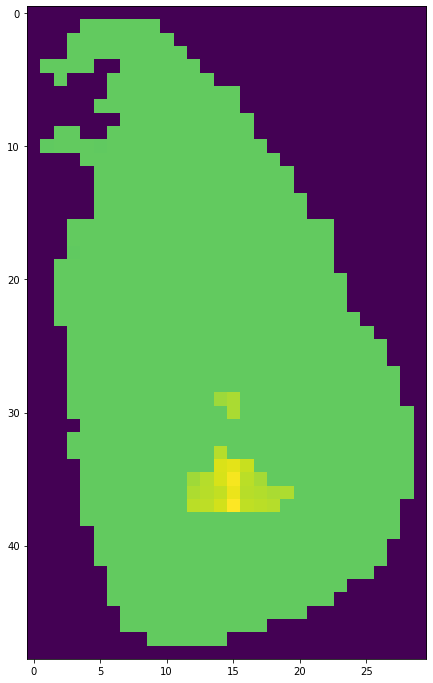

In [5]:
plt.figure(figsize = (12,12))
plt.imshow(data, cmap='viridis')
plt.show()

**Note!**

Rasterio imports raster files as 2-d arrays. The dimensions of the array are related to the spatial resolution of the imported layer. Individual values can be access in common practice as in numpy arrays. 

### Import tif and transform it to point vector

In [6]:
# Define functions

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]+(geotransform[1]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    originY = geotransform[3]+(geotransform[5]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn, band_no):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(band_no)    # Be aware of the band you need here
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTString))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
        if ridx % 10 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            index = str(ridx) + "_" + str(cidx)
            Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
            point.AddPoint(Xcoord, Ycoord)
            # Create the feature and set values
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(point)
            outFeature.SetField("VALUE", str(index))
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy()
            #outDS.Destroy()
    print ("\nProcess completed!")

def main(rasterfn,outSHPfn, band_no):
    array = raster2array(rasterfn, band_no)
    array2shp(array,outSHPfn,rasterfn)

In [7]:
# Provide the input raster and give a name to the output transformed vector
raster = out_path + "\\" + raster_nm
outSHP = out_path + "\\" + shp_nm

# Run the function
main(raster,outSHP, band_no=3)

0 of 49 rows processed
10 of 49 rows processed
20 of 49 rows processed
30 of 49 rows processed
40 of 49 rows processed

Process completed!


### Import vector point layer into a geo-dataframe

In [8]:
# Create a new geo-dataframe
data_gdf = gpd.read_file(out_path + "\\" + shp_nm)

# Assign crs
data_gdf.crs = crs_WGS84

In [9]:
data_gdf.head(3)

,VALUE,geometry
0,0_0,POINT (79.54167 9.87500)
1,0_1,POINT (79.62500 9.87500)
2,0_2,POINT (79.70833 9.87500)


**Note!**

VALUE has been retrieved from the ascii file; it denotes the number of row and column in the initial layer, split by the underscore delimiter. We may use the following function to a) split them into two different columns and b) create a tuple from their combination (this is needed in case we follow the CLEWs clustering approach). 

In [10]:
def create_rowcol_columns(df):
    
    # Split the Value to rows and columns
    split = df["VALUE"].str.split("_", n = 1, expand = True)
    
    # Drop the VALUE as it has served its purpose
    df = df.drop(["VALUE"], axis=1)
    
    # Add the separate columns back to the dataframe
    df["row"] = split[0]
    df["col"] = split[1]
    
    # Change dtype of columns from str to int
    df["row"] = df["row"].astype(np.int)
    df["col"] = df["col"].astype(np.int)
    
    # Create a tuple id to use for merging later on
    df["id"] = list(zip(df.row, df.col)) 
    
    return df

In [11]:
data_gdf = create_rowcol_columns(data_gdf)

In [12]:
data_gdf.head(3)

,geometry,row,col,id
0,POINT (79.54167 9.87500),0,0,"(0, 0)"
1,POINT (79.62500 9.87500),0,1,"(0, 1)"
2,POINT (79.70833 9.87500),0,2,"(0, 2)"


## Step 2. Assign cluster name to points

In [13]:
def cleaning_string_attributes(df, column_name):
    df[column_name].replace("-", '_', regex=True, inplace=True)
    df[column_name].replace(" ", '_', regex=True, inplace=True)
    df[column_name].replace("/", '_', regex=True, inplace=True)
    df[column_name].replace("'", '_', regex=True, inplace=True)
    df[column_name].replace("é", 'e', regex=True, inplace=True)
    df[column_name].replace("î", 'i', regex=True, inplace=True)
    df[column_name].replace("ï", 'i', regex=True, inplace=True)
    df[column_name].replace("ô", 'o', regex=True, inplace=True)
    df[column_name].replace("è", 'e', regex=True, inplace=True)
    df[column_name].replace("à", 'a', regex=True, inplace=True)
    df[column_name].replace("", 'NaN', regex=True, inplace=True)
    df[column_name].fillna(value=np.nan, inplace=True)
    return df

**Note!**

The admin column names used in the code (e.g. "ADM1_NAME, or "NAME_0) might require changing depending on the source of those layers.

In [14]:
## Import admin layer accordingly

if clust_method == 1:
    
    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin1_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "ADM1_NAME")
    
    #Spatial join
    data_gdf_admin = gpd.sjoin(data_gdf, admin[["geometry", "ADM1_NAME"]], op='within').drop(['index_right'], axis=1)
    data_gdf_admin.rename(columns={'ADM1_NAME': 'cluster'}, inplace=True)
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(data_gdf_admin, on=["id"], how="left").drop(['id','row_y', 'col_y', "geometry_y"], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col', 'geometry_x': 'geometry'}, inplace=True)
    clustered_GAEZ_gdf = gpd.GeoDataFrame(clustered_GAEZ_gdf, geometry="geometry")
    
    
elif clust_method == 2:

    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin2_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "ADM2_NAME")
    
    #Spatial join
    data_gdf_admin = gpd.sjoin(data_gdf, admin[["geometry", "ADM2_NAME"]], op='within').drop(['index_right'], axis=1)
    data_gdf_admin.rename(columns={'ADM2_NAME': 'cluster'}, inplace=True)
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(data_gdf_admin, on=["id"], how="left").drop(['id','row_y', 'col_y', "geometry_y"], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col', 'geometry_x': 'geometry'}, inplace=True)
    clustered_GAEZ_gdf = gpd.GeoDataFrame(clustered_GAEZ_gdf, geometry="geometry")
    
    
elif clust_method == 3:
    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin0_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "NAME_0")
    
    # Import csv as pandas dataframe
    cluster_data = pd.read_csv(in_path + "\\" + clust_nm)
    # Create a tuple id to be used for merging
    cluster_data['id'] = list(zip(cluster_data.row, cluster_data.col))
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(cluster_data, on=["id"], how="left").drop(['id','row_y', 'col_y'], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col'}, inplace=True)
    
else:
    print ("Please specify clustering method to proceed")

In [15]:
clustered_GAEZ_gdf.sample(3)

,geometry,row,col,cluster
1134,POINT (81.54167 6.79167),37,24,Uva
684,POINT (81.54167 8.04167),22,24,NaN
176,POINT (81.70833 9.45833),5,26,NaN


At this point each vector point represents a particular location on the map -it has certain coordinates- and is categorized into a cluster based on the users selection.

## Step 3. Converting points to polygons
This allows further flexibility in the extraction of raster values using stats. In any case we have the lat,lon coordinates of each point so it is easy to revert to the point geometry. Here, we create a rectangular, buffer-based polygon around each point. 

The buffered polygon shall split "equally" the area between neighbor points; therefore, the buffer used shall be the half of the distance between two neighbor points. This, in turn depends on the location of the AoI on earth and the projection system used. 

We suggest two approaches described below.

### Assigning CRS | projecting | adding lat, lon coordinates in degrees

In [16]:
clustered_GAEZ_gdf.crs = crs_WGS84

In [17]:
clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y

<ipython-input-17-c1a650f5b317>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
<ipython-input-17-c1a650f5b317>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y


In [18]:
clustered_GAEZ_gdf.head(2)

,geometry,row,col,cluster,lon,lat
0,POINT (79.54167 9.87500),0,0,NaN,79.541667,9.875
1,POINT (79.62500 9.87500),0,1,NaN,79.625000,9.875


### Estimating buffer radious

**Approach 1** (suggested)

Here, we estimate the buffer by calculating the haversine distance between two neighbor points; we use the median value of lat. 

In [19]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [20]:
# We select a randon set of neighbors; the gdf should be sorted thus here using the median index
index_1 = clustered_GAEZ_gdf[clustered_GAEZ_gdf.lat == clustered_GAEZ_gdf.lat.median()].index.tolist()[1]
index_2 = int(index_1 + 1)

# Note! We multiply by 1000 for meters and devide by 2 as we want half of the distance between the two points
clustered_GAEZ_gdf['buf_val_1'] = round(haversine(clustered_GAEZ_gdf["lon"][index_1],
                                                  clustered_GAEZ_gdf["lat"][index_1],
                                                  clustered_GAEZ_gdf["lon"][index_2],
                                                  clustered_GAEZ_gdf["lat"][index_2])*1000/2)

**Approach 2**

Here we use an empirical formula to estimate the "latmeters". That is, we estimate the equivalent value of a degree magnitude in meters based on the latitude of a location. Therefore, each point in the dataframe is assigned a slightly different buffer.

In [21]:
def find_buffer_from_lat(lat, res=resolution):
    """
    Calculate meters per latitude value 
    INPUT 
    lat: latitude in degrees
    res: resolution of original raster layer
    OUTPUT
    latlen: Estimated value of buffer for polygon creation in meters
    """ 
    latlen = (111132.954 - 559.822 * cos(2*lat) + 1.175 * cos(4*lat))*res/2
    return latlen
# Emperical formula retrieved from https://gis.stackexchange.com/questions/75528/understanding-terms-in-length-of-degree-formula

In [22]:
## Un-comment to run
#clustered_GAEZ_gdf['buf_val_2'] =clustered_GAEZ_gdf['lat'].apply(find_buffer_from_lat)

### Create polygons based on identified buffer

#### Project dataframe to the proper coordinate system

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the "EPSG" part)**.

**NOTE** When selecting your coordinate system make sure that you select a system with the unit of meters, this is indicated for all systems on [epsg.io](http://epsg.io/)

In [23]:
clustered_GAEZ_gdf_prj = clustered_GAEZ_gdf.to_crs(crs_proj)

#### ... and create the polygons 

Note! You can replace *'buf_val_1'* to *'buf_val_2'* if you find the second approach fit for purpose.

In [24]:
## cap_style refers to the type of geometry generated; 3=rectangular (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)
clustered_GAEZ_gdf_prj['geometry'] = clustered_GAEZ_gdf_prj.apply(lambda x:
                                                                  x.geometry.buffer(x.buf_val_1, cap_style=3), axis=1)

**... and revert the dataframe to the original CRS**

In [25]:
clustered_GAEZ_gdf = clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

**Note!** Several features are not classified into a cluster. While points away of the administrative borders will be cut out of the analysis, some points right next to the outer administrative borders might create inconsistency when calculating area. In the following section we are dealing with this problem.

## Step 4. Fixing missing values

### Adding an index column
(for easier identification/selection later on)

In [26]:
clustered_GAEZ_gdf['index'] = range(1, len(data_gdf)+1)

### Reduce running types | reassure expected output

**Note** 

The following part may lead to varying running times. In favor of reducing running times, we may clip of the vector polygons to the country extent using **national administrative boundaries** 

Clipping will not create any problems to landlocked countries (e.g. Ethiopia) as their borders are mostly covered by land. Therefore recommended in such cases.

However, for coastal or island countries (e.g. Sri Lanka) the algorithm may miss border clusters with very little land cover (e.g. few disperse, small islands). In order to prevent this from happening, we run the nearest neighbor algorithm over the whole extent of the gridded country and clip to the country extent at the end.

You may run either of the versions as you see necessary; here we use the **"landlocked"** variable to make a simple distinction between the two. 

In [27]:
# Clip based on topology of the selected country
if landlocked == 1:
    clustered_GAEZ_gdf = gpd.clip(clustered_GAEZ_gdf, admin)
else:
    clustered_GAEZ_gdf = clustered_GAEZ_gdf

### Split vector points based on cluster assignment 

In [28]:
# Change type of cluster column to string for next step's selection
clustered_GAEZ_gdf.cluster = clustered_GAEZ_gdf.cluster.astype(str)

Points within admin boundaries that are assigned to a cluster

In [29]:
clustered_GAEZ_gdf_non_nan = clustered_GAEZ_gdf[clustered_GAEZ_gdf["cluster"] != "nan"]
clustered_GAEZ_gdf_non_nan.geometry = clustered_GAEZ_gdf_non_nan.geometry.centroid
clustered_GAEZ_gdf_non_nan.head(3)

<ipython-input-29-ddada813bf57>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_non_nan.geometry = clustered_GAEZ_gdf_non_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
35,POINT (79.95833 9.79167),1,5,Northern,79.958333,9.791667,4589,36
36,POINT (80.04167 9.79167),1,6,Northern,80.041667,9.791667,4589,37
37,POINT (80.12500 9.79167),1,7,Northern,80.125000,9.791667,4589,38


Points within admin boundaries but not assigned to a cluster

In [30]:
clustered_GAEZ_gdf_nan = clustered_GAEZ_gdf[clustered_GAEZ_gdf["cluster"] == "nan"]
clustered_GAEZ_gdf_nan.geometry = clustered_GAEZ_gdf_nan.geometry.centroid
clustered_GAEZ_gdf_nan.head(3)

<ipython-input-30-465c0ec06b28>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_nan.geometry = clustered_GAEZ_gdf_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
0,POINT (79.54167 9.87500),0,0,nan,79.541667,9.875,4589,1
1,POINT (79.62500 9.87500),0,1,nan,79.625000,9.875,4589,2
2,POINT (79.70833 9.87500),0,2,nan,79.708333,9.875,4589,3


### Get nearest neighbor for points not assigned

In [31]:
# Simple function getting the nearest hub for a given set of points
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [32]:
# Apply fuction to the non cluster points dataframe
clustered_GAEZ_gdf_nan["index_nn"] = clustered_GAEZ_gdf_nan.apply(calculate_nearest,
                                                                               destination=clustered_GAEZ_gdf_non_nan,
                                                                               val="index",
                                                                               axis=1)

C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


The dataframe has now been attributed with the index of the nearest neighbor 

In [33]:
clustered_GAEZ_gdf_nan.head(3)

,geometry,row,col,cluster,lon,lat,buf_val_1,index,index_nn
0,POINT (79.54167 9.87500),0,0,nan,79.541667,9.875,4589,1,65
1,POINT (79.62500 9.87500),0,1,nan,79.625000,9.875,4589,2,65
2,POINT (79.70833 9.87500),0,2,nan,79.708333,9.875,4589,3,65


### Merge the two split dataframe 

This action works similar to the VLOOKUP fuction in excel. For each index_nn in the first dataframe looks at the index of the second dataframe and assigns attributes to the primer as per need. In this case, we assign the cluster name of the nearest neighbor.

In [34]:
clustered_GAEZ_gdf_nan_n = clustered_GAEZ_gdf_nan.merge(clustered_GAEZ_gdf_non_nan[['index','cluster']],
                                                                      how = "left",
                                                                      left_on = "index_nn",
                                                                      right_on='index').drop(["index_nn", "cluster_x","index_x"], axis=1)

In [35]:
clustered_GAEZ_gdf_nan_n.rename(columns={'index_y': 'index', 'cluster_y': 'cluster'}, inplace=True)

### Concatenate the two split dataframes into a single one
(updating the original clipped dataframe)

In [36]:
clustered_GAEZ_gdf_new = clustered_GAEZ_gdf_non_nan.append(clustered_GAEZ_gdf_nan_n)

In [37]:
clustered_GAEZ_gdf_new.head(2)

,geometry,row,col,cluster,lon,lat,buf_val_1,index
35,POINT (79.95833 9.79167),1,5,Northern,79.958333,9.791667,4589,36
36,POINT (80.04167 9.79167),1,6,Northern,80.041667,9.791667,4589,37


### And finally, merge back to the clipped polygon layer using spatial join
(this is to re-gain the polygon geometry)

In [38]:
#Spatial join
final_clustered_GAEZ_gdf = gpd.sjoin(clustered_GAEZ_gdf_new, clustered_GAEZ_gdf[["geometry"]], op='within', how='right')

### Clip results in case of coastal or island countries

In [39]:
if landlocked == 1:
    final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf
else:
    final_clustered_GAEZ_gdf = gpd.clip(final_clustered_GAEZ_gdf, admin)

## Step 5. Total area re-estimation & calibration

This step estimates and calibrates the area (in square km) based on the area provided by the admin layer used in the analysis (e.g. clipping). 

In [40]:
# project datasets to proper crs
final_clustered_GAEZ_gdf_prj = final_clustered_GAEZ_gdf.to_crs(crs_proj)
admin_proj = admin.to_crs(crs_proj)

In [41]:
final_clustered_GAEZ_gdf_prj["sqkm"] = final_clustered_GAEZ_gdf_prj['geometry'].area/10**6

In [42]:
def get_multiplier(estimated, official):
    if official == estimated:
        return 1
    try:
        return  official / estimated
    except ZeroDivisionError:
        return 0

In [43]:
estimated_area = final_clustered_GAEZ_gdf_prj.sqkm.sum()
official_area = admin_proj.geometry.area.sum()/10**6

# Estimate column multipler
multiplier = get_multiplier(estimated_area, official_area)

In [44]:
final_clustered_GAEZ_gdf_prj.sqkm = final_clustered_GAEZ_gdf_prj.sqkm * multiplier

In [45]:
print ("Our modelling exercise yields a total area of {0:.1f} sqkm for the country".format(estimated_area))
print ("The admin layer indicates {0:.1f} sqkm".format(official_area))
print ("After calibration the total area is set at {0:.1f} sqkm".format(final_clustered_GAEZ_gdf_prj.sqkm.sum()))

Our modelling exercise yields a total area of 65783.7 sqkm for the country
The admin layer indicates 66126.9 sqkm
After calibration the total area is set at 66126.9 sqkm


## Final check and export result of Part 1

### Revert to original CRS

In [46]:
final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

### Make a final check

In [47]:
final_clustered_GAEZ_gdf.head(2)

,index_left,row,col,cluster,lon,lat,buf_val_1,index,geometry,sqkm
8,8,0,8,Northern,80.208333,9.875000,4589,39,"POLYGON ((80.21857 9.83352, 80.20567 9.83349, ...",0.161502
34,34,1,4,Northern,79.875000,9.791667,4589,36,"MULTIPOLYGON (((79.91689 9.77569, 79.91697 9.7...",8.078459


### Export 

In [48]:
# Export as geopackage
final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=output_nm)),driver="GPKG")
print ("Part 1 complete!", "\U0001F913")

Part 1 complete! 🤓


# Part 2 - Adding raster attributes to vector polygons

This part employs a number of functions that extract values from raster layers and attribute them to the vector layer generated in Part 1.

You will need any continuous of categorical raster layer in *.tif* format (placed inside the *global_raster_input* directory)

**Note!** Raster layers can be added based on the mandates of the analysis. However, there is the following naming conventions that need to be followed for the code to properly work.
 - Any crop related raster layer should contain the 3-letter code in the name (e.g. cwd_mai_irr_hig_bas.tif where mai=maize)
 - Any non-crop related raster layer shall contain the suffix _ncr in their name (e.g. LCType_ncr.tif)

## Define functions

In [49]:
# Processing Continuous/Numerical Rasters
def processing_raster_con(path, raster, prefix, method, clusters):
    """
    This function calculates stats for numerical rasters and attributes them to the given vector features. 
    
    INPUT: 
    name: string used as prefix when assigning features to the vectors
    method: statistical method to be used (check documentation)
    clusters: the vector layer containing the clusters
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """

    raster=rasterio.open(path + '\\' + raster)
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        stats=[method],
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return clusters

In [50]:
## Processing Categorical/Discrete Rasters
def processing_raster_cat(path, raster, prefix, clusters):
    """
    This function calculates stats for categorical rasters and attributes them to the given vector features. 
    
    INPUT: 
    path: the directory where the raster layer is stored 
    raster: the name and extention of the raster layer 
    prefix: string used as prefix when assigning features to the vectors
    clusters: the vector layer containing the clusters
    
    OUTPUT:
    geojson file of the vector features including the new attributes
    """    
    raster=rasterio.open(path + '\\' + raster)
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        categorical=True,
        prefix=prefix, geojson_out=True, all_touched=True)
    
    print("{} processing completed at".format(prefix), datetime.datetime.now())
    return clusters

In [51]:
## Converting geojson to geodataframe
def geojson_to_gdf(workspace, geojson_file):
    """
    This function returns a geodataframe for a given geojson file
    
    INPUT: 
    workplace: working directory
    geojson_file: geojson layer to be convertes
    crs: projection system in epsg format (e.g. 'EPSG:32637')
    
    OUTPUT:
    geodataframe
    """
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(geojson_file)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    print("cluster created anew at", datetime.datetime.now())
    return clusters

## Collect raster names and type from directory

In [52]:
# Read files with tif extension and assign their name into two list for discrete and continuous datasets
raster_files_dis = []
raster_files_con =[]

for i in os.listdir(in_path_raster):
    for crop in crop_name:
        if (crop in i) and i.endswith('.tif'):
            with rasterio.open(in_path_raster + '\\' + i) as src:
                data = src.read() 
                unique_val = len(np.unique(data))
                if unique_val < 20:                                   # This value is arbitrary
                    raster_files_dis.append(i)
                else:
                    raster_files_con.append(i)
                
for j in os.listdir(in_path_raster):
    if ("ncr" in j) and j.endswith('.tif'):
        with rasterio.open(in_path_raster + '\\' + j) as src:
            data = src.read() 
            unique_val = len(np.unique(data))
            if unique_val < 20:                                   # This value is arbitrary
                raster_files_dis.append(j)
            else:
                raster_files_con.append(j)
                
# keep only unique values -- Not needed but just in case there are dublicates
raster_files_con = list(set(raster_files_con))
raster_files_dis = list(set(raster_files_dis))
                
print ("We have identified {} continuous raster(s):".format(len(raster_files_con)),"\n",)
for raster in raster_files_con:
    print ( "*", raster)
    
print ("\n", "We have identified {} discrete raster(s):".format(len(raster_files_dis)),"\n",)
for raster in raster_files_dis:
    print ( "*", raster)

We have identified 7 continuous raster(s): 

* evt_whe_rai_int_base.tif
* yie_whe_irr_hig_bas.tif
* cwd_whe_rai_int_bas.tif
* evt_mai_irr_hig_bas.tif
* rai_bas_ncr.tif
* yie_whe_rai_int_bas.tif
* cwd_mai_irr_hig_bas.tif

 We have identified 1 discrete raster(s): 

* LCType_ncr.tif


## Extract raster values 

In [53]:
clusters = final_clustered_GAEZ_gdf

### Continuous datasets (e.g. rainfall, yield, evapotranspiration, GHI etc.)

In [54]:
for raster in raster_files_con:
    prefix = raster.strip(".tif")
    prefix = prefix.rstrip('_ncr')
    
    # Calling the extraction function for discrete layers
    clusters = processing_raster_con(in_path_raster, raster, prefix, "mean", clusters)

evt_whe_rai_int_base processing completed at 2020-12-21 14:50:07.515036
yie_whe_irr_hig_bas processing completed at 2020-12-21 14:50:11.165937
cwd_whe_rai_int_bas processing completed at 2020-12-21 14:50:14.921371
evt_mai_irr_hig_bas processing completed at 2020-12-21 14:50:18.581480
rai_bas processing completed at 2020-12-21 14:50:22.291749
yie_whe_rai_int_bas processing completed at 2020-12-21 14:50:25.963565
cwd_mai_irr_hig_bas processing completed at 2020-12-21 14:50:29.660423


### Discrete datasets (e.g. Land cover type)

Note that the Land Cover layer used follows `International Geosphere-Biosphere Programme (IGBP) classification` (see [here](https://smap.jpl.nasa.gov/system/internal_resources/details/original/284_042_landcover.pdf) for more info).

In [55]:
for raster in raster_files_dis:
    prefix = raster.strip(".tif")
    prefix = prefix.rstrip('_ncr')
    
    # Calling the extraction function for discrete layers
    clusters = processing_raster_cat(in_path_raster, raster, prefix, clusters)

C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


LCType processing completed at 2020-12-21 14:50:34.234277


## Converting the geojson file to geodataframe

**NOTE** In case you get an Driver Error for reading the geojson file into a geodataframe, this might be cause due to attribution of "inf" or "-inf" value in one of the attributes. This is related to the way python handles json (see fix [here](https://stackoverflow.com/questions/17503981/is-there-a-way-to-override-pythons-json-handler)). An "easy" fix is that you import the geojson into Qgis and replace the erroneous value(s) manually. This is not ideal but it will do the job. In that case, save the updated geojson file and use the second (commented) line below to import into a geodataframe.

In [56]:
clusters = geojson_to_gdf(out_path, clusters)

cluster created anew at 2020-12-21 14:50:34.912090


## Exporting the geodataframe as vector layer

In [57]:
# Export as shapefile 
clusters.to_file(os.path.join(out_path,"{c}.gpkg".format(c=result_nm)),driver="GPKG")
print ("Part 2 complete!", "\U0001F60E")

Part 2 complete! 😎


# Part 3 - Calculating summary stats for clusters

This part calculates summary statistics for the generated clusters. There outputs include:

* Tabular summaries (.csv format) at national level
* Tabular summaries (.csv format) grouped by cluster
* Interactive graphs (.html) for key attributes per cluster

#### Collect name of attributes assigned to the clusters

In [58]:
origin_list_of_cols = list(final_clustered_GAEZ_gdf.columns)
final_list_of_cols = list(clusters.columns)

## National summary stats

### Land cover and area stats

In [59]:
# Land cover area estimator
def calc_LC_sqkm(df, col_list):
    """ 
    This function takes the df where the LC type for different classes is provided per location (row).
    It adds all pixels per location; then is calculates the ratio of LC class in each location (% of total).
    Finally is estimates the area per LC type in each location by multiplying with the total area each row represents.
    
    INPUT: 
    df -> Pandas dataframe with LC type classification 
    col_list -> list of columns to include in the summary (e.g. LC0-LC16)
    
    OUTPUT: Updated dataframe with estimated area (sqkm) of LC types per row
    """
    df["LC_sum"] = df[col_list].sum(axis=1)
    for col in col_list:
        df[col] = df[col]/df["LC_sum"]*df["sqkm"]
    
    return df

In [60]:
# Identify land cover related columns
landCover_cols = []
for col in final_list_of_cols:
    if "LCType" in col:
        landCover_cols.append(col)
if not landCover_cols:
    print ("There is not any Land Cover associated column in the dataframe; please revise")
else:
    pass

In [61]:
data_gdf_LCsqkm = calc_LC_sqkm(clusters, landCover_cols)

In [62]:
# list of stast to be calculated
lc_sum_rows = ['sum', 'min', 'max']

# initiate the summary table 
LC_summary_table = pd.DataFrame(index=lc_sum_rows, columns=landCover_cols)

# filling in the table
for col in landCover_cols:
    LC_summary_table[col][0] = round(data_gdf_LCsqkm[col].sum(),2)
    LC_summary_table[col][1] = round(data_gdf_LCsqkm[col].min(),2)
    LC_summary_table[col][2] = round(data_gdf_LCsqkm[col].max(),2)

In [63]:
display(Markdown('###  These are the summarized results for land cover (sq.km) in **{}**'.format(country_name)))
display(Markdown(' **Total area:** {:0.1f} sq.km'.format(data_gdf_LCsqkm.sqkm.sum())))
display(LC_summary_table)
display(Markdown('#### Class Description \n\n LCType0 - Water \n\n LCType1 - Evergreen Needleleaf Forest \n\n LCType2 - Evergreen Broadleaf Forest \n\n  LCType3 - Deciduous Needleleaf Forest \n\n LCType4 - Deciduous Broadleaf Forest \n\n LCType5 - Mixed Forests \n\n LCType6 - Closed Shrublands \n\n LCType7 - Open Shrublands \n\n LCType8 - Woody Savannas \n\n LCType9 - Savannas \n\n LCType10 - Grasslands \n\n LCType11 - Permanent Wetlands \n\n LCType12 - Croplands \n\n LCType13 - Urban and Built-Up \n\n LCType14 - Cropland/Natural Vegetation Mosaic \n\n LCType15 - Snow and Ice \n\n LCType16 - Barren or Sparsely Vegetated'))

###  These are the summarized results for land cover (sq.km) in **lka**

 **Total area:** 66126.9 sq.km

,LCType11,LCType13,LCType0,LCType10,LCType12,LCType14,LCType16,LCType8,LCType4,LCType9,LCType2,LCType6,LCType7,LCType5,LCType3,LCType1
sum,1371.24,304.99,688.86,304.34,5118.25,28107.9,209.7,1696.13,64.31,3369.52,24653.5,43.92,50.84,129.46,13.39,0.48
min,0,0.04,0,0,0.05,0.03,0.03,0.1,0.1,0.1,0.1,0.05,0.12,0,0.09,0.19
max,26.46,45.6,23.01,15.2,66.68,84.68,8.16,62.87,3.91,43.61,84.68,2.98,5,2.89,1,0.29


#### Class Description 

 LCType0 - Water 

 LCType1 - Evergreen Needleleaf Forest 

 LCType2 - Evergreen Broadleaf Forest 

  LCType3 - Deciduous Needleleaf Forest 

 LCType4 - Deciduous Broadleaf Forest 

 LCType5 - Mixed Forests 

 LCType6 - Closed Shrublands 

 LCType7 - Open Shrublands 

 LCType8 - Woody Savannas 

 LCType9 - Savannas 

 LCType10 - Grasslands 

 LCType11 - Permanent Wetlands 

 LCType12 - Croplands 

 LCType13 - Urban and Built-Up 

 LCType14 - Cropland/Natural Vegetation Mosaic 

 LCType15 - Snow and Ice 

 LCType16 - Barren or Sparsely Vegetated

### Other variables

In [64]:
# Calculate summary statistics for other than land cover attribute columns
final_list_of_cols = list(data_gdf_LCsqkm.columns)
sum_cols = [x for x in final_list_of_cols if x not in origin_list_of_cols]
sum_cols = [x for x in sum_cols if x not in landCover_cols]
sum_cols.remove("id")
sum_cols.remove("LC_sum")

# 
sum_rows = ['mean', 'min', 'max']

other_summary_table = pd.DataFrame(index=sum_rows, columns=sum_cols)

for col in sum_cols:
    other_summary_table[col][0] = round(data_gdf_LCsqkm[col].mean(),2)
    other_summary_table[col][1] = round(data_gdf_LCsqkm[col].min(),2)
    other_summary_table[col][2] = round(data_gdf_LCsqkm[col].max(),2)

In [65]:
display(Markdown('###  \n These are the summarized results for the rest of the variables collected for **{}**'.format(country_name)))
display(other_summary_table)
display(Markdown('### Note! \n Units are similar to the original source; you may refer to the [documantation]() for more info.'))

###  
 These are the summarized results for the rest of the variables collected for **lka**

,evt_whe_rai_int_basemean,yie_whe_irr_hig_basmean,cwd_whe_rai_int_basmean,evt_mai_irr_hig_basmean,rai_basmean,yie_whe_rai_int_basmean,cwd_mai_irr_hig_basmean
mean,13.4,8,0.03,558.77,1708.81,0.06,98.66
min,0,-0.01,0,415,973,-0.01,1
max,507,11.48,1,729,2642,2.87,344


### Note! 
 Units are similar to the original source; you may refer to the [documantation]() for more info.

### Export national stats to csv

In [66]:
#Export national stats to csv
LC_summary_table.to_csv(os.path.join(summary_stats_path,"{}_LandCover_National_summary.csv".format(country_name)))
other_summary_table.to_csv(os.path.join(summary_stats_path,"{}_Variable_National_summary.csv".format(country_name)))

## Calculating Cluster Summaries

In [67]:
data_gdf_LCsqkm["cluster"] = data_gdf_LCsqkm["cluster"].astype(str)
non_clustered_data = data_gdf_LCsqkm[data_gdf_LCsqkm["cluster"] == "None"]

display(Markdown('**Note** that there are {} polygons that are not assigned to a cluster  -- classified as "None"'
                 .format(len(non_clustered_data))))

**Note** that there are 0 polygons that are not assigned to a cluster  -- classified as "None"

### Groupby on clusters

In [68]:
clusters = data_gdf_LCsqkm.groupby(['cluster'])

### Land cover and area

In [69]:
clusters_lc = clusters[landCover_cols].sum().merge(clusters["sqkm"].sum(), on="cluster").round(decimals = 1)

In [70]:
clusters_lc.sort_values(ascending=False, by='sqkm').reset_index()
display(Markdown('#### Cluster summary statistics for area and land cover in {}'.format(country_name)))
clusters_lc

#### Cluster summary statistics for area and land cover in lka

,LCType11,LCType13,LCType0,LCType10,LCType12,LCType14,LCType16,LCType8,LCType4,LCType9,LCType2,LCType6,LCType7,LCType5,LCType3,LCType1,sqkm
cluster,,,,,,,,,,,,,,,,,
Central,78.1,16.5,1.7,0.2,228.8,1894.7,0.0,89.8,0.4,59.3,3384.0,0.4,0.2,3.6,0.2,0.0,5757.9
Eastern,316.5,66.9,172.9,31.4,1435.3,4185.0,75.2,217.5,16.2,1165.4,2051.3,21.0,4.5,33.1,2.8,0.3,9795.1
North_Central,236.3,9.2,18.0,0.2,1155.6,5501.3,0.4,153.9,2.4,736.2,2927.2,2.5,0.0,9.7,0.8,0.0,10753.7
North_Western,135.2,16.8,111.5,45.0,559.5,5351.7,22.0,56.7,0.6,38.3,1714.9,2.0,2.3,9.4,1.6,0.0,8067.4
Northern,234.3,8.9,258.9,215.7,1032.4,2524.0,100.3,272.8,12.7,295.9,4097.1,14.5,42.9,38.0,4.3,0.0,9152.6
Sabaragamuwa,28.6,4.7,1.7,0.0,23.5,1099.5,0.0,21.0,0.4,21.8,3709.4,0.0,0.0,0.6,0.0,0.0,4911.2
Southern,191.8,14.9,46.8,3.4,443.5,2308.9,9.9,324.1,14.8,142.4,2055.0,1.6,0.2,13.9,3.3,0.2,5574.7
Uva,95.0,4.4,16.9,0.2,149.9,3539.4,0.4,529.9,14.2,904.1,3025.9,1.3,0.2,16.1,0.2,0.0,8298.2
Western,55.4,162.7,60.3,8.2,89.8,1703.5,1.4,30.6,2.5,6.2,1688.9,0.8,0.6,5.0,0.2,0.0,3816.2


In [71]:
#Export national stats to csv
clusters_lc.to_csv(os.path.join(summary_stats_path,"{}_LandCover_byCluster_summary.csv".format(country_name)))

### Other variable summaries

In [72]:
clusters_other = clusters[sum_cols].mean().round(decimals = 2)

In [73]:
display(Markdown('#### Cluster summary statistics for other variables in {}'.format(country_name)))
clusters_other

#### Cluster summary statistics for other variables in lka

,evt_whe_rai_int_basemean,yie_whe_irr_hig_basmean,cwd_whe_rai_int_basmean,evt_mai_irr_hig_basmean,rai_basmean,yie_whe_rai_int_basmean,cwd_mai_irr_hig_basmean
cluster,,,,,,,
Central,122.34,5.69,0.28,551.33,1992.68,0.52,7.24
Eastern,0.00,8.24,0.00,571.70,1656.41,0.00,135.36
North_Central,0.00,9.93,0.00,570.26,1464.41,0.00,129.23
North_Western,0.00,8.17,0.00,560.64,1601.55,-0.00,79.29
Northern,0.00,11.24,0.00,578.11,1138.42,-0.00,252.56
Sabaragamuwa,0.00,5.59,0.00,527.84,2333.16,0.00,3.66
Southern,0.00,6.02,0.00,543.99,2098.95,0.00,26.42
Uva,35.18,5.96,0.09,538.47,1831.47,0.14,20.53
Western,0.00,5.61,0.00,542.23,2398.43,0.00,12.94


In [74]:
#Export national stats to csv
clusters_other.to_csv(os.path.join(summary_stats_path,"{}_Parameter_byCluster_summary.csv".format(country_name)))

### Generate interactive graphs

In [75]:
start_time = time.time()

In [76]:
def make_interactive_graph_sum(clust_dict, parameter, name):
    for key, value in clust_dict.items():
        clust_dict[key] = round(clusters.get_group(key)[parameter].sum(),2)
    fig_Cluster = px.bar(pd.DataFrame.from_dict(clust_dict, orient='index', columns=["sum"]), title="Dictribution of {} over clusters in {}".format(parameter, country_name))
    #fig_Cluster.show()
    # Export figure as html
    fig_Cluster.write_html((os.path.join(summary_stats_path,"{}_{}_{}_perCluster.html".format(name, parameter, "sum"))))

In [77]:
def make_interactive_graph_mean(clust_dict, parameter, name):
    for key, value in clust_dict.items():
        clust_dict[key] = round(clusters.get_group(key)[parameter].mean(),2)
    fig_Cluster = px.bar(pd.DataFrame.from_dict(clust_dict, orient='index', columns=["mean"]), title="Dictribution of {} over clusters in {}".format(parameter, country_name))
    #fig_Cluster.show()
    # Export figure as html
    fig_Cluster.write_html((os.path.join(summary_stats_path,"{}_{}_{}_perCluster.html".format(name, parameter, "mean"))))

In [78]:
# Get cluster names
clust_names = list(data_gdf_LCsqkm.cluster.unique())

# Create a dictionary that includes the name of the clusters and a selected parameter
clust_dict = dict.fromkeys(clust_names, 1)

In [79]:
landCover_cols.append("sqkm")

for item in landCover_cols:
    make_interactive_graph_sum(clust_dict, item, country_name) 
    
for col in sum_cols:
    make_interactive_graph_mean(clust_dict, col, country_name) 

In [80]:
print ("Part 3 - and with that the analysis - completed!", "\U0001F44A")
print ("Process completed in {:0.2f} min".format((time.time()-start_time)/60))

Part 3 - and with that the analysis - completed! 👊
Process completed in 0.05 min
